I work with a bunch of different datasets. One big challenge with this is keeping track of which dataset is which and where they all are. Maybe you recognize the problem. One standard solution to this is to use a data catalog, and the PyData ecosystem happens to have a nice tool for working with data catalogs, [intake](https://intake.readthedocs.io/en/latest/overview.html). A couple of years ago I wrote a [blog post about using intake to handle some chemistry file formats](http://rdkit.blogspot.com/2019/07/using-intake-for-chemistry-data.html) and that inspired me to write a small intake plugin which added support for working with SDF and SMILES files using intake.

I've been meaning to do a blog post describing the plugin and how to use it, but somehow never got around to it. However, this week we published a [preprint](https://chemrxiv.org/engage/chemrxiv/article-details/6406049e6642bf8c8f10e189) that includes some datasets (Aside: the preprint introduces SIMPD, an algorithm for splitting chemical datasets into training and test sets which differ from each other in the same ways that time splits constructed from medicinal chemistry project data do.) with an intake data catalog. The data sets and intake description are included in the [GitHub repo for the paper].(https://github.com/rinikerlab/molecular_time_series/tree/main/datasets). That's provided the impetus for me to finally do a quick blog post describing how to use intake for chemistry datasets.

This is just a quick one, to show the basics of working with intake and the RDKit, but hopefully it's enough to make you want to start using the system. Feedback on either this post or the RDKit plugin for intake are very welcome.


# Getting started

The RDKit plugin is in GitHub: https://github.com/greglandrum/intake-rdkit
I haven't setup packages for it yet, but you can install it directly from the repo like this:
```
python -m pip install git+https://github.com/greglandrum/intake-rdkit.git
```
You do need to have both the `intake` and `rdkit` packages as well.

In [10]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
PandasTools.RenderImagesInAllDataFrames(True)
import rdkit
print(rdkit.__version__)

2022.09.5


In [2]:
import intake
import pandas as pd

# Basics

Let's start at the end: open the data catalog from github and then read one of the SIMPD datasets into a Pandas dataframe. Here I grab the data directly from the GitHub repo, but I could just as easily have worked from a local copy of the files:

,mol,Unnamed: 0,compound_chembl_id,canonical_smiles,standard_value,standard_units,standard_relation,standard_type,pchembl_value,pActivity,active,split
0,,229,CHEMBL1256953,CN(C)c1cc2c(Nc3ccc4c(c3)ncn4Cc3ccccc3)ncnc2cn1,3162.28,nM,=,IC50,5.5,5.5,1,train
1,,398,CHEMBL375270,O=C(Nc1ccccc1)c1cc([N+](=O)[O-])ccc1Cl,10000.00,nM,=,IC50,5.0,5.0,0,train
2,,280,CHEMBL15192,CC1(C)CCC2=C(O1)c1ccccc1C(=O)C2=O,10000.00,nM,=,IC50,5.0,5.0,0,train
3,,422,CHEMBL441618,CN1CCc2ccccc2Cc2[nH]c3ccccc3c2CC1,5011.87,nM,=,IC50,5.3,5.3,1,train
4,,263,CHEMBL1393,CC(=O)S[C@@H]1CC2=CC(=O)CC[C@]2(C)[C@H]2CC[C@@...,12589.25,nM,=,IC50,4.9,4.9,0,test

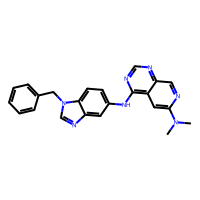
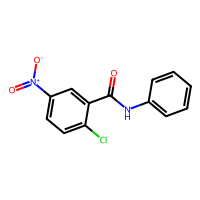
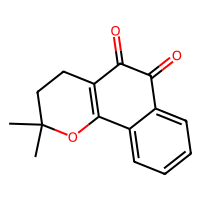
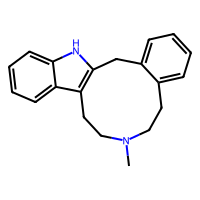
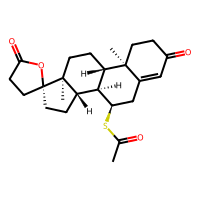

In [14]:
rawbase = 'https://raw.githubusercontent.com/rinikerlab/molecular_time_series/main'
catalog = intake.open_catalog(f'{rawbase}/datasets/public_data.yaml')
ds = catalog.SIMPD.CHEMBL1267245
df = ds.read()
df.head()

That's a pandas `DataFrame`, so we can take advantage of all that they support. Here we retrieve rows that are marked as active and which have a aromatic five-ring containing an N:

,mol,Unnamed: 0,compound_chembl_id,canonical_smiles,standard_value,standard_units,standard_relation,standard_type,pchembl_value,pActivity,active,split
3,,422,CHEMBL441618,CN1CCc2ccccc2Cc2[nH]c3ccccc3c2CC1,5011.87,nM,=,IC50,5.30,5.300000,1,train
20,,39,CHEMBL1200517,CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...,2254.00,nM,=,IC50,5.65,5.647046,1,train
26,,77,CHEMBL123,Cc1c2ccncc2c(C)c2c1[nH]c1ccccc12,0.56,nM,=,IC50,9.25,9.251812,1,train
31,,490,CHEMBL605003,CN(C)S(=O)(=O)c1ccc2c(c1)/C(=C/c1cc3c([nH]1)CC...,3981.07,nM,=,IC50,5.40,5.400000,1,test
40,,507,CHEMBL772,COC(=O)[C@H]1[C@H]2C[C@@H]3c4[nH]c5cc(OC)ccc5c...,1995.26,nM,=,IC50,5.70,5.700001,1,train

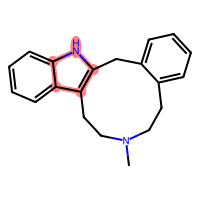
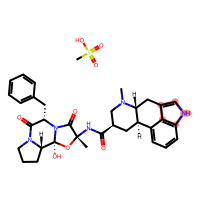
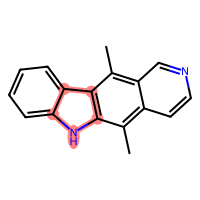
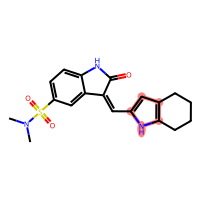
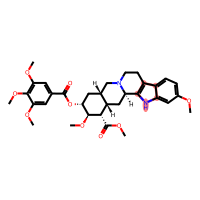

In [13]:
mols = df[(df.active==1) & (df.mol>=Chem.MolFromSmarts('c1cccn1'))]
mols.head()

In the previous example I directly accessed a particular dataset that I knew was there.

I could have also looped over the available datasets:

In [20]:
catalog = intake.open_catalog(f'{rawbase}/datasets/public_data.yaml')
for i,assay in enumerate(catalog.SIMPD):
    print(assay)
    if i>=4: break

CHEMBL1267247
CHEMBL3705464
CHEMBL3705282
CHEMBL1267250
CHEMBL3705791


# Metadata

The individual datasets have metadata in the catalog:

In [19]:
catalog.SIMPD[assay].metadata.keys()

dict_keys(['url', 'source', 'activity_type', 'min pchembl_value', 'max pchembl_value', 'median pchembl_value', 'is_log_data', 'activity bin', 'Compounds', 'Num Active', 'Num Inactive', 'catalog_dir'])

And we can use that as a filter. Note that commands like this take a few seconds to run when accessing the catalog from github. Using a local copy is much faster.

In [24]:
large_assays = [assay for assay in catalog.SIMPD if catalog.SIMPD[assay].metadata['Compounds']>700]
large_assays

['CHEMBL3705362', 'CHEMBL3705899', 'CHEMBL3706373']

In [25]:
catalog.SIMPD['CHEMBL3705899'].metadata

{'url': 'https://www.ebi.ac.uk/chembl/assay_report_card/CHEMBL3705899/',
 'source': 'ChEMBL_30',
 'activity_type': 'IC50',
 'min pchembl_value': 4.61,
 'max pchembl_value': 9.0,
 'median pchembl_value': 6.96,
 'is_log_data': True,
 'activity bin': 7.2,
 'Compounds': 766,
 'Num Active': 304,
 'Num Inactive': 462,
 'catalog_dir': 'https://raw.githubusercontent.com/rinikerlab/molecular_time_series/main/datasets'}

Of course the catalogs themselves also have metadata:

In [27]:
catalog.metadata

{'version': 1,
 'creator': {'name': 'greg landrum', 'email': 'glandrum@ethz.ch'},
 'summary': 'Collection of datasets from the publication\nG.A. Landrum, M. Beckers, J. Lanini, N. Schneider, N. Stiefl, S. Riniker \n"SIMPD: an Algorithm for Generating Simulated Time Splits for Validating Machine Learning Approaches"\nhttps://chemrxiv.org/engage/chemrxiv/article-details/6406049e6642bf8c8f10e189\n\nPlease cite our paper if you use these datasets.    \n'}

In [28]:
catalog.SIMPD.metadata

{'version': 1,
 'creator': {'name': 'greg landrum', 'email': 'glandrum@ethz.ch'},
 'summary': 'Collection of datasets with pchembl_values for bioactivity prediction.\n\nEach row includes the reported value. Only values without data_validity_comments are included\nActive/inactive class assignments were done to give a 40/60 inactive/active ratio\nThe suggested train/test split was created using the SIMPD algorithm, described in the publication\nhttps://chemrxiv.org/engage/chemrxiv/article-details/6406049e6642bf8c8f10e189\n',
 'split_column': 'split',
 'class_column': 'active',
 'activity_column': 'standard_value'}

# Supported formats

The RDKit intake integration currently supports two formats:

  - SDF
  - SMILES: this can be any delimited text file which includes a column with SMILES
  
 Either format can be read from either compressed or uncompressed files.

# Creating data descriptions

Catalogs and datasets in intake are described in YAML files. You can, of course, create these by hand, but it's certainly more efficient to create them programmatically. Here's the code I used to do this for the raw ChEMBL assays in our preprint, derived from one of the notebooks in the [GitHub repo](https://github.com/rinikerlab/molecular_time_series/blob/main/01_Get_ChEMBL30_Bioactivity_Data_assays.ipynb):

```
yaml=[]
# loop over assay IDs:
for aid,achemblid in zip(aids,achemblids):
    # retrieve the assay data from ChEMBL:
    d = %sql postgresql://localhost/chembl_30 \
select distinct on (cil.chembl_id) cil.chembl_id compound_chembl_id,canonical_smiles, \
        standard_value,standard_units,standard_relation,standard_type,pchembl_value \
          from activities join assays using(assay_id) \
          join compound_structures using(molregno) \
          join chembl_id_lookup cil on (molregno=entity_id and entity_type='COMPOUND') \
          where pchembl_value is not null  \
            and standard_value is not null and standard_units = 'nM' \
            and data_validity_comment is null \
            and assay_id=:aid \
          order by cil.chembl_id;
    # convert that to a pandas dataframe and write a CSV file:
    df = d.DataFrame()
    df.to_csv(f'./datasets/source_data/assay_{achemblid}.csv.gz',index=False)
    
    # generate the metadata we care about:
    minAct = min(df.pchembl_value)
    maxAct = max(df.pchembl_value)
    medAct = np.median(df.pchembl_value)
    actTypes = list(set(df.standard_type))
    if len(actTypes)>1:
        print(f'SKIPPING {achemblid} since it has {len(actTypes)} different activity types.')
        continue
    actType = actTypes[0]
    assayd = %sql postgresql://localhost/chembl_30 \
    select * from assays  \
        where assay_id=:aid
    assayd = dict(assayd[0])
    # quotes in the description cause problems with the yaml parsing
    assayd['description'] = assayd['description'].replace('"','')
    
    # create the YAML for this dataset:
    template=f'''  {achemblid}:
    description: "Assay {achemblid}: {assayd['description']}"
    args:
      filename: '{{{{ CATALOG_DIR }}}}/source_data/assay_{achemblid}.csv.gz'
      smilesColumn: canonical_smiles
    metadata:
      url: https://www.ebi.ac.uk/chembl/assay_report_card/{achemblid}/
      source: ChEMBL_30
      activity_type: {actType}
      min pchembl_value: {minAct:.2f}
      max pchembl_value: {maxAct:.2f}
      median pchembl_value: {medAct:.2f}
    driver: intake_rdkit.smiles.SmilesSource
'''
    yaml.append(template)

# print the YAML to the notebook
print('\n'.join(yaml))

# and write the full data catalog file:
with open('./datasets/assays.yaml','w+') as outf:
    header='''metadata:
  version: 1
  creator: 
    name: greg landrum
    email: glandrum@ethz.ch

  summary: |
    Collection of datasets with pchembl_values for bioactivity prediction.

    Each row includes the reported value. Only values without data_validity_comments are included
    
sources:'''
    print(header,file=outf)
    print('\n'.join(yaml),file=outf)```
